In [17]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")


In [18]:
# Cell 2: Load and prepare data
df = pd.read_csv(
    'preprocessed_powerconsumption_hourly.csv',
    parse_dates=['Datetime'],
    dayfirst=True
)
df.set_index('Datetime', inplace=True)
df = df.asfreq('H')



In [8]:
# Cell 3: define features and targets
features = [
    'TimeOfDay',
    'Season',
    'Temperature',
    'Humidity',
    'WindSpeed',
    'GeneralDiffuseFlows',
    'DiffuseFlows'
]
targets = [
    'PowerConsumption_Zone1',
    'PowerConsumption_Zone2',
    'PowerConsumption_Zone3'
]

In [9]:
# Cell 4: compute correlation matrix
corr_matrix = df[features + targets].corr()

In [10]:
# Cell 5: extract and sort correlations for each zone
for zone in targets:
    corr_with_zone = corr_matrix[zone][features]
    corr_sorted = corr_with_zone.abs().sort_values(ascending=False)
    
    print(f'\nTop correlations for {zone}:')
    print(corr_sorted)


Top correlations for PowerConsumption_Zone1:
Temperature            0.444210
Humidity               0.290947
TimeOfDay              0.241499
GeneralDiffuseFlows    0.221468
DiffuseFlows           0.179364
WindSpeed              0.169573
Season                 0.118446
Name: PowerConsumption_Zone1, dtype: float64

Top correlations for PowerConsumption_Zone2:
Temperature            0.384847
Humidity               0.297845
TimeOfDay              0.187507
GeneralDiffuseFlows    0.186252
WindSpeed              0.147993
DiffuseFlows           0.136088
Season                 0.094712
Name: PowerConsumption_Zone2, dtype: float64

Top correlations for PowerConsumption_Zone3:
Temperature            0.491652
TimeOfDay              0.358435
Season                 0.309412
WindSpeed              0.276819
Humidity               0.233165
GeneralDiffuseFlows    0.103702
DiffuseFlows           0.040084
Name: PowerConsumption_Zone3, dtype: float64


In [19]:
# Cell 4: clean non-numeric and drop NaNs
for col in features + targets:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=features + targets)


In [20]:
# Cell 5: find best (p,d,q) by AIC for each zone
orders = {}
for zone in targets:
    best_aic = np.inf
    best_order = None

    for p in range(4):
        for d in range(3):
            for q in range(4):
                try:
                    m = SARIMAX(
                        df[zone],
                        exog=df[features],
                        order=(p, d, q)
                    )
                    r = m.fit(disp=False)
                    if r.aic < best_aic:
                        best_aic = r.aic
                        best_order = (p, d, q)
                except:
                    pass

    orders[zone] = best_order
    print(f"{zone} best order: {best_order} (AIC={best_aic:.0f})")


PowerConsumption_Zone1 best order: (2, 2, 2) (AIC=188706)
PowerConsumption_Zone2 best order: (3, 1, 2) (AIC=181253)
PowerConsumption_Zone3 best order: (3, 2, 3) (AIC=182373)


In [21]:
# Cell 6: fit SARIMAX for each zone
models = {}
results = {}

for zone, order in orders.items():
    m = SARIMAX(df[zone], exog=df[features], order=order)
    r = m.fit(disp=False)
    models[zone] = m
    results[zone] = r
    print(f"{zone} fitted with order {order}")


PowerConsumption_Zone1 fitted with order (2, 2, 2)
PowerConsumption_Zone2 fitted with order (3, 1, 2)
PowerConsumption_Zone3 fitted with order (3, 2, 3)


In [23]:
# Cell 7: (optional) inspect coefficient p-values
for zone, res in results.items():
    print(f"\n=== {zone} exog p-values ===")
    print(res.summary().tables[1])



=== PowerConsumption_Zone1 exog p-values ===
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
TimeOfDay             973.1014    235.704      4.128      0.000     511.130    1435.072
Season              -1267.6992      2.094   -605.531      0.000   -1271.802   -1263.596
Temperature           356.4234    340.933      1.045      0.296    -311.793    1024.640
Humidity               98.5183     54.928      1.794      0.073      -9.139     206.176
WindSpeed             319.4816    299.461      1.067      0.286    -267.452     906.415
GeneralDiffuseFlows     4.0493      2.047      1.978      0.048       0.038       8.061
DiffuseFlows          -26.6081      2.217    -12.001      0.000     -30.954     -22.263
ar.L1                   1.5541      0.009    167.679      0.000       1.536       1.572
ar.L2                  -0.6983      0.011    -64.992      0.000      -0.71

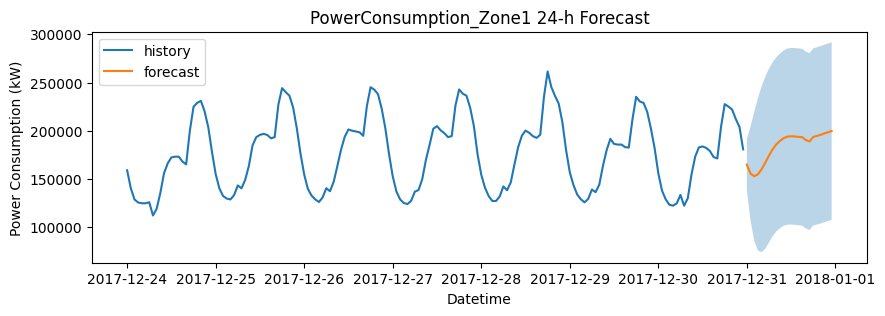

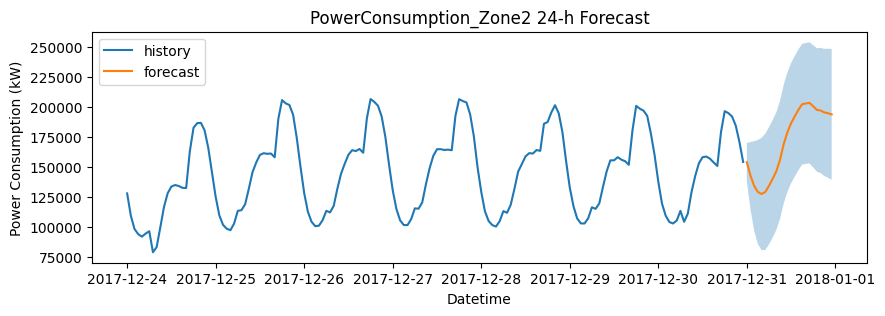

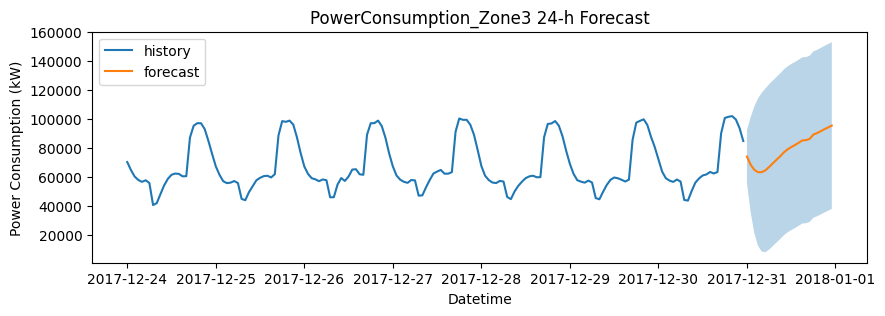

In [ ]:
# Cell 8: forecast next 24 hours with exogenous inputs
n_steps = 24

# 1. Build a future datetime index
last_ts = df.index[-1]
future_index = pd.date_range(
    start=last_ts + pd.Timedelta(hours=1),
    periods=n_steps,
    freq='H'
)

# 2. Create future exog DataFrame
future_exog = pd.DataFrame(index=future_index)
# cyclical features
future_exog['TimeOfDay'] = future_index.hour
# you may need to map month->season exactly as in your training data
future_exog['Season']    = ((future_index.month % 4) + 1)  # example mapping
# for the numeric exogs, here we simply repeat the last observed block
for col in ['Temperature','Humidity','WindSpeed',
            'GeneralDiffuseFlows','DiffuseFlows']:
    future_exog[col] = df[col].iloc[-n_steps:].values

# 3. Forecast each zone using its fitted result
for zone, res in results.items():
    f    = res.get_forecast(steps=n_steps, exog=future_exog)
    mean = f.predicted_mean
    ci   = f.conf_int()

    # plot
    plt.figure(figsize=(10,3))
    plt.plot(df[zone].iloc[-168:], label='history')
    plt.plot(future_index, mean, label='forecast')
    plt.fill_between(
        future_index,
        ci.iloc[:,0],
        ci.iloc[:,1],
        alpha=0.3
    )
    plt.title(f"{zone} 24-h Forecast")
    plt.xlabel("Datetime")
    plt.ylabel("Power Consumption (kW)")
    plt.legend()
    plt.show()


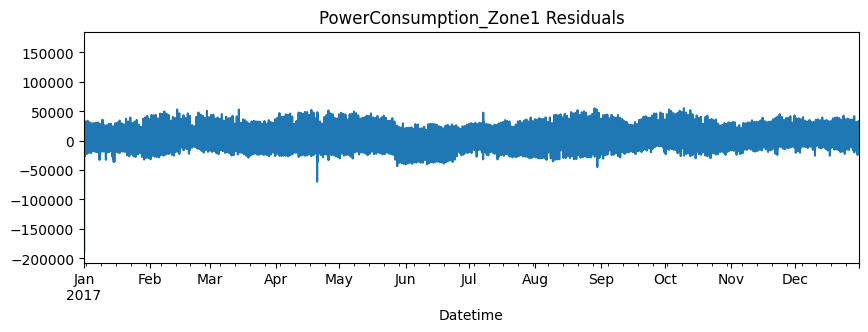

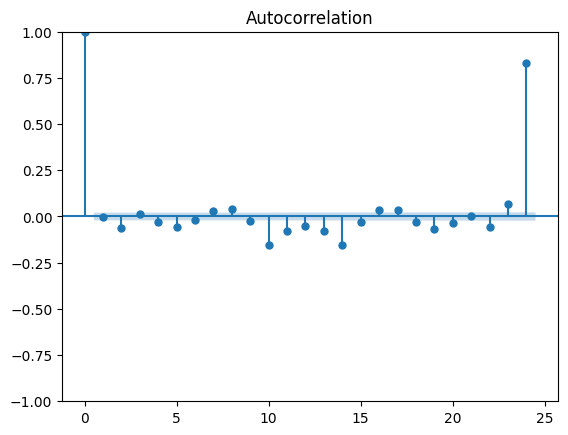

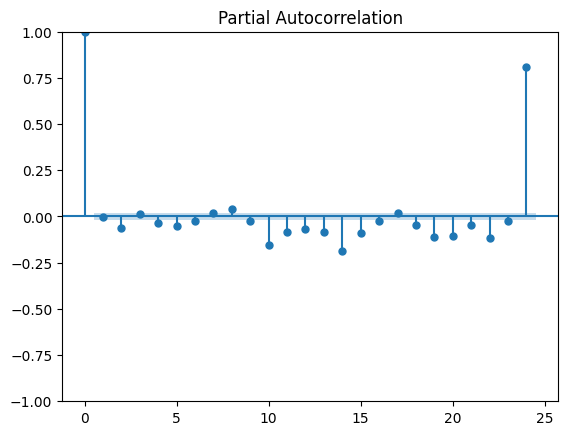

PowerConsumption_Zone1 Ljung–Box p-value: 0.0


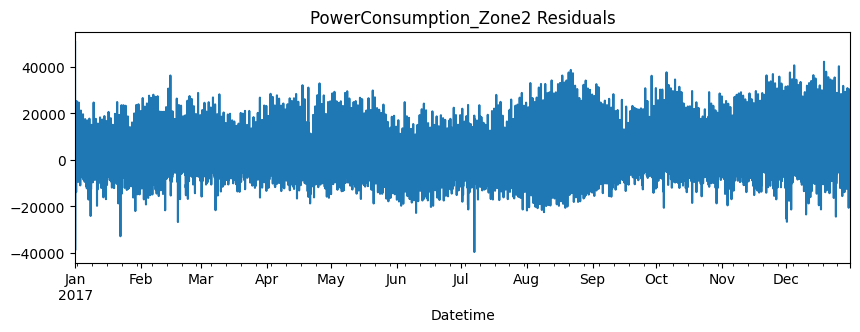

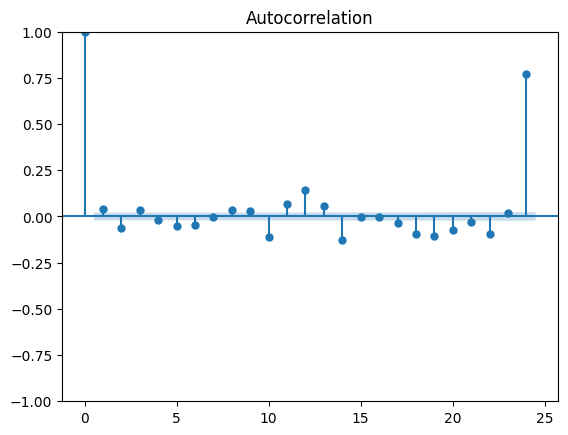

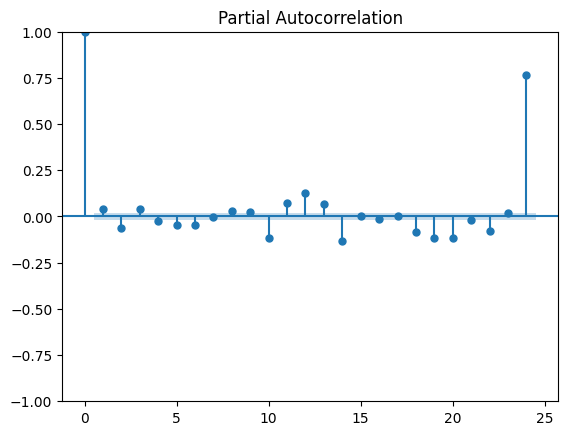

PowerConsumption_Zone2 Ljung–Box p-value: 0.0


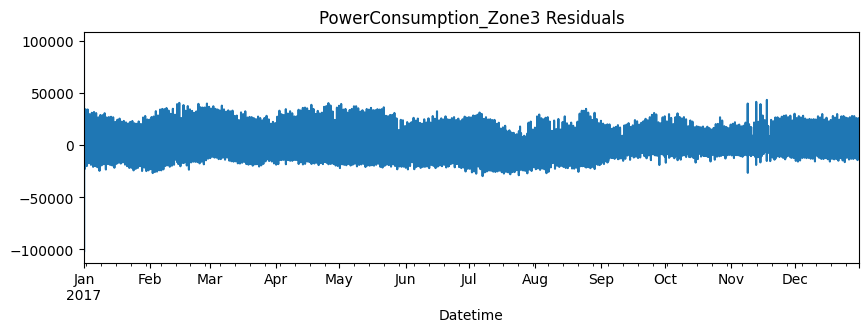

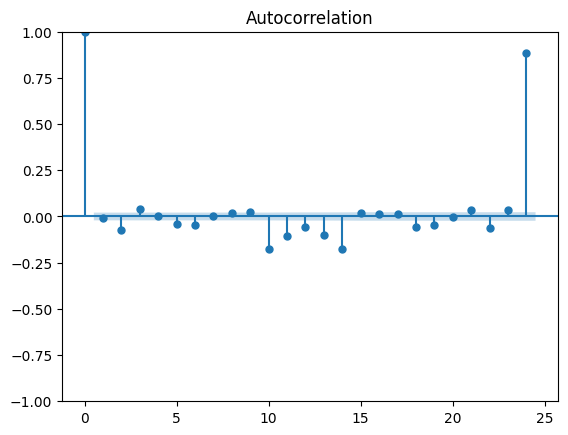

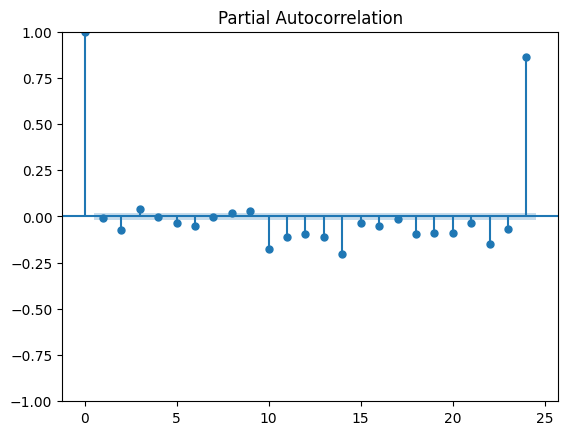

PowerConsumption_Zone3 Ljung–Box p-value: 0.0


In [26]:
# Cell 9: Residual diagnostics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

for zone, res in results.items():
    resid = res.resid
    resid.plot(figsize=(10,3), title=f'{zone} Residuals')
    plt.show()
    plot_acf(resid, lags=24)
    plt.show()
    plot_pacf(resid, lags=24)
    plt.show()
    lb = acorr_ljungbox(resid, lags=[24], return_df=True)
    print(f'{zone} Ljung–Box p-value:', lb["lb_pvalue"].values[0])


In [27]:
# Cell 10: Hold-out validation and accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

test_size = 168  # last week
train = df.iloc[:-test_size]
test  = df.iloc[-test_size:]

# refit on train only
trained = {}
for zone, order in orders.items():
    m = SARIMAX(train[zone], exog=train[features], order=order)
    trained[zone] = m.fit(disp=False)

# forecast and score
for zone, res in trained.items():
    f = res.get_forecast(steps=test_size, exog=test[features])
    pred = f.predicted_mean
    rmse = np.sqrt(mean_squared_error(test[zone], pred))
    mae  = mean_absolute_error(test[zone], pred)
    mape = np.mean(np.abs((test[zone] - pred) / test[zone])) * 100
    print(f"{zone}  RMSE:{rmse:.2f}, MAE:{mae:.2f}, MAPE:{mape:.2f}%")


PowerConsumption_Zone1  RMSE:37105.70, MAE:32012.52, MAPE:19.27%
PowerConsumption_Zone2  RMSE:30786.12, MAE:26126.54, MAPE:19.18%
PowerConsumption_Zone3  RMSE:16886.11, MAE:12190.60, MAPE:16.31%


In [28]:
# Cell 11: Baseline comparisons
# 1) Last-value persistence
for zone in targets:
    last = train[zone].iloc[-1]
    base = pd.Series(last, index=test.index)
    rmse = np.sqrt(mean_squared_error(test[zone], base))
    print(f"{zone} persistence RMSE: {rmse:.2f}")

# 2) Seasonal naive (same hour 24h ago)
for zone in targets:
    pred_sn = test.index.map(lambda t: df[zone].loc[t - pd.Timedelta(hours=24)])
    pred_sn = pd.Series(pred_sn, index=test.index)
    rmse = np.sqrt(mean_squared_error(test[zone], pred_sn))
    print(f"{zone} seasonal-naive RMSE: {rmse:.2f}")


PowerConsumption_Zone1 persistence RMSE: 38219.02
PowerConsumption_Zone2 persistence RMSE: 34236.53
PowerConsumption_Zone3 persistence RMSE: 21554.16
PowerConsumption_Zone1 seasonal-naive RMSE: 10169.49
PowerConsumption_Zone2 seasonal-naive RMSE: 10576.75
PowerConsumption_Zone3 seasonal-naive RMSE: 2254.90


In [29]:
# Cell 12: Drop exogs with p>0.05 and refit
for zone, res in results.items():
    pvals = res.pvalues[features]
    drop  = pvals[pvals > .05].index.tolist()
    keep  = [f for f in features if f not in drop]
    print(f"{zone} drop: {drop}")
    m2 = SARIMAX(df[zone], exog=df[keep], order=orders[zone])
    r2 = m2.fit(disp=False)
    print(f"{zone} new AIC: {r2.aic:.0f}")


PowerConsumption_Zone1 drop: ['Temperature', 'Humidity', 'WindSpeed']
PowerConsumption_Zone1 new AIC: 188701
PowerConsumption_Zone2 drop: ['Season']
PowerConsumption_Zone2 new AIC: 181251
PowerConsumption_Zone3 drop: ['WindSpeed', 'GeneralDiffuseFlows']
PowerConsumption_Zone3 new AIC: 182376


In [30]:
# Cell 13: Add a seasonal term (daily) and compare AIC
for zone in targets:
    p,d,q = orders[zone]
    m_seas = SARIMAX(
        df[zone],
        exog=df[features],
        order=(p,d,q),
        seasonal_order=(1,0,1,24)
    )
    r_seas = m_seas.fit(disp=False)
    print(f"{zone} seasonal AIC: {r_seas.aic:.0f}")


PowerConsumption_Zone1 seasonal AIC: 183247
PowerConsumption_Zone2 seasonal AIC: 175283
PowerConsumption_Zone3 seasonal AIC: 176481
